### Парсим данные ММРО-ИОИ: vocab, docword и cooc в расширенном UCI-формате.

In [1]:
import artm.messages_pb2, artm.library
parser_config = artm.messages_pb2.CollectionParserConfig()
parser_config.format = artm.library.CollectionParserConfig_Format_VowpalWabbit
parser_config.dictionary_file_name = 'dictionary'
parser_config.docword_file_path = 'datasets/mmro_order/vw.mmro.txt'
parser_config.target_folder = 'datasets/mmro_order'
parser_config.num_items_per_batch = 100
artm.library.Library().ParseCollection(collection_parser_config = parser_config)

In [4]:
import artm.messages_pb2, artm.library
parser_config = artm.messages_pb2.CollectionParserConfig()
parser_config.use_symmetric_cooc_values = False
parser_config.use_unity_based_indices = False
parser_config.format = artm.library.CollectionParserConfig_Format_Cooccurrence
parser_config.dictionary_file_name = 'condprob_w100_dictionary'
parser_config.docword_file_path = 'datasets/mmro/condprob_w100.mmro.txt'
parser_config.vocab_file_path = 'datasets/mmro/vocab.mmro.txt'
parser_config.target_folder = 'datasets/mmro'
artm.library.Library().ParseCollection(collection_parser_config = parser_config)

In [3]:
import artm.messages_pb2, artm.library
parser_config = artm.messages_pb2.CollectionParserConfig()
parser_config.format = artm.library.CollectionParserConfig_Format_BagOfWordsUci
parser_config.dictionary_file_name = 'dictionary'
parser_config.docword_file_path = 'datasets/mmro/docword.mmro.txt'
parser_config.vocab_file_path = 'datasets/mmro/vocab.mmro.txt'
parser_config.target_folder = 'datasets/mmro'
parser_config.num_items_per_batch = 100
artm.library.Library().ParseCollection(collection_parser_config = parser_config)

### Делаем подготовительные операции для обучения моделей в интерфейсе ARTM.

In [1]:
%matplotlib inline
import glob
import matplotlib.pyplot as plt
import artm

batch_vectorizer = artm.BatchVectorizer(data_path='datasets/mmro_order', data_format='batches')

background_topics = []
domain_topics = []
all_topics = []

for i in range(0, 60):
    topic_name = "topic" + str(i)
    all_topics.append(topic_name)
    if i < 50:
        domain_topics.append(topic_name)
    else:
        background_topics.append(topic_name)
        
def prepare(model):
    model.load_dictionary(dictionary_name='dictionary', dictionary_path='datasets/mmro_order/dictionary')
    model.initialize(dictionary_name='dictionary')
    # will this cooc dictionaries match?
    model.load_dictionary(dictionary_name='pPMI_w100', dictionary_path='datasets/mmro/pPMI_w100_dictionary')
    model.load_dictionary(dictionary_name='pPMI_doc', dictionary_path='datasets/mmro/pPMI_doc_dictionary')
 
    model.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                      use_unigram_document_model=False, # где-то сохраняется, сколько раз pwd = 0?
                                      dictionary_name='dictionary'))

    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', 
                                           topic_names = domain_topics))

    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore', 
                                            topic_names = domain_topics))

    model.scores.add(artm.TopTokensScore(name='DomainTop10_pPMI_w100', 
                                         num_tokens=10, 
                                         dictionary_name = 'pPMI_w100',
                                         topic_names = domain_topics))

    model.scores.add(artm.TopTokensScore(name='DomainTop100_pPMI_w100', 
                                         num_tokens=100, 
                                         dictionary_name = 'pPMI_w100',
                                         topic_names = domain_topics))
    
    model.scores.add(artm.TopTokensScore(name='DomainTop10_pPMI_doc', 
                                         num_tokens=10, 
                                         dictionary_name = 'pPMI_doc',
                                         topic_names = domain_topics))

    model.scores.add(artm.TopTokensScore(name='DomainTop100_pPMI_doc', 
                                         num_tokens=100, 
                                         dictionary_name = 'pPMI_doc',
                                         topic_names = domain_topics))

    model.scores.add(artm.TopTokensScore(name='BackgroundTopTokensScore', 
                                         num_tokens=10, 
                                         topic_names = background_topics))

    model.scores.add(artm.TopicKernelScore(name='DomainTopicKernel_pPMI_w100', 
                                           probability_mass_threshold=0.25, 
                                           dictionary_name = 'pPMI_w100',
                                           topic_names = domain_topics))
    
    model.scores.add(artm.TopicKernelScore(name='DomainTopicKernel_pPMI_doc', 
                                           probability_mass_threshold=0.25, 
                                           dictionary_name = 'pPMI_doc',
                                           topic_names = domain_topics))

    model.scores.add(artm.TopicKernelScore(name='BackgroundTopicKernelScore', 
                                           probability_mass_threshold=0.25, 
                                           topic_names = background_topics))
    
    model.scores.add(artm.TopicMassPhiScore(name='BackgroundMassScore',  
                                           topic_names = background_topics))

def figures(model):
    # row and column sharing
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', figsize=(15,8))
    plt.subplots_adjust(hspace = 0.3, wspace = 0.25)
    #f.set_size_inches(18.5, 10.5)
    
    # perplexity
    x = range(model.num_phi_updates)[1:]
    ax1.plot(x, model.score_tracker['PerplexityScore'].value[1:], 'g-', linewidth=2, label="Perplexity")
    ax1.set_ylabel('Perplexity', color='g')
    ax11 = ax1.twinx()
    ax11.plot(x, model.score_tracker['SparsityPhiScore'].value[1:], 'r*', linewidth=2, label="Phi")
    ax11.plot(x, model.score_tracker['SparsityThetaScore'].value[1:], 'r--', linewidth=2, label="Theta ")
    ax11.plot(x, model.score_tracker['BackgroundMassScore'].value[1:], 'r^', linewidth=2, label="Back")
    ax11.set_ylabel('Ratio', color='r')
    ax11.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
    ax1.grid(True)
    
    # kernels
    x = range(model.num_phi_updates)[1:]
    ax2.plot(x, model.score_tracker['DomainTopicKernel_pPMI_w100'].average_size[1:], 'g-', linewidth=2, label="size")
    ax2.set_ylabel('Kernel size', color='g')
    ax22 = ax2.twinx()
    ax22.plot(x, model.score_tracker['DomainTopicKernel_pPMI_w100'].average_contrast[1:], 'r*', linewidth=2, label="contrast")
    ax22.plot(x, model.score_tracker['DomainTopicKernel_pPMI_w100'].average_purity[1:], 'r--', linewidth=2, label="purity")
    ax22.set_ylabel('Ratio', color='r')
    ax22.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
    ax2.grid(True)
    
    # coherence
    x = range(model.num_phi_updates)[1:]
    ax3.plot(x, model.score_tracker['DomainTop10_pPMI_w100'].average_coherence[1:], 'b--', label="top10", linewidth=2)
    ax3.plot(x, model.score_tracker['DomainTop100_pPMI_w100'].average_coherence[1:], 'r--', label="top100", linewidth=2)
    ax3.plot(x, model.score_tracker['DomainTopicKernel_pPMI_w100'].average_coherence[1:], 'g--', label="kernel", linewidth=2)
    ax3.set_ylabel('Window100 pPMI coherence')
    ax3.set_xlabel('Iterations count')
    ax3.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
    ax3.grid(True) 
    
    # coherence
    x = range(model.num_phi_updates)[1:]
    ax4.plot(x, model.score_tracker['DomainTop10_pPMI_doc'].average_coherence[1:], 'b--', label="top10", linewidth=2)
    ax4.plot(x, model.score_tracker['DomainTop100_pPMI_doc'].average_coherence[1:], 'r--', label="top100", linewidth=2)
    ax4.plot(x, model.score_tracker['DomainTopicKernel_pPMI_doc'].average_coherence[1:], 'g--', label="kernel", linewidth=2)
    ax4.set_ylabel('Document pPMI coherence')
    ax4.set_xlabel('Iterations count')
    ax4.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
    #ax4.legend(loc=2)
    ax4.grid(True)

     

### Модели

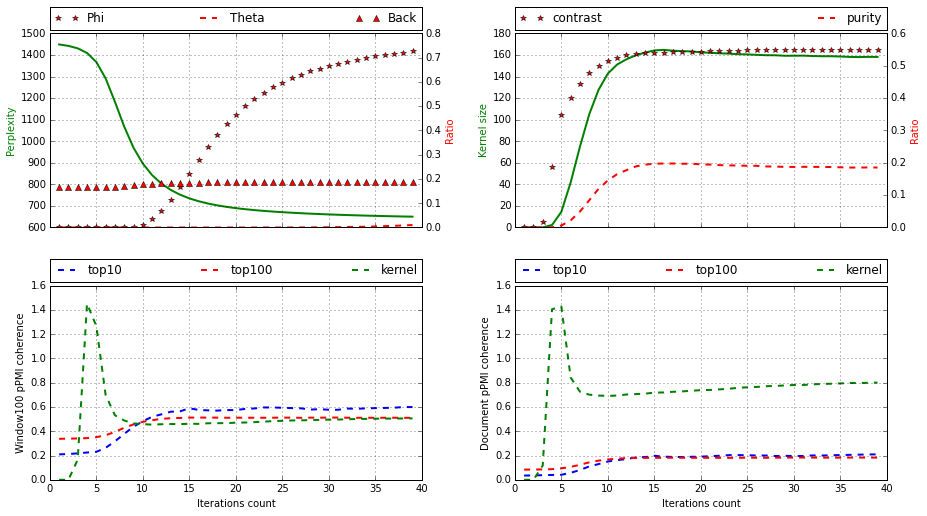

In [2]:
# PLSA
model = artm.ARTM(topic_names = all_topics)
prepare(model)
# no ptdw regularization
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40, 
                  use_ptdw_matrix=True, ptdw_reg_mode=0)
figures(model)

In [ ]:
# PLSA
model = artm.ARTM(topic_names = all_topics)
prepare(model)
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40, 
                  use_ptdw_matrix=True, ptdw_reg_mode=1, ptdw_reg_window=100, ptdw_reg_tau=0.1)
figures(model)

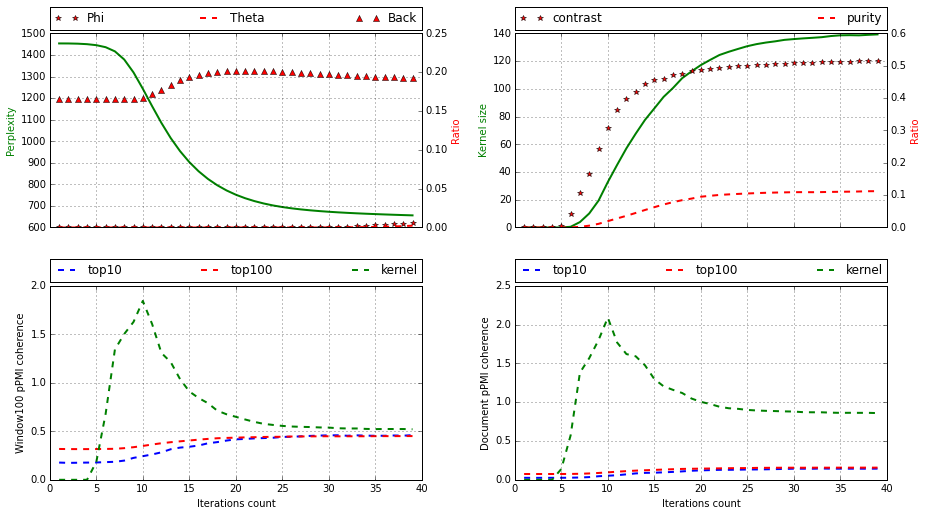

In [2]:
# PLSA
model = artm.ARTM(topic_names = all_topics)
prepare(model)
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40, 
                  use_ptdw_matrix=True, ptdw_reg_mode=1, ptdw_reg_window=100, ptdw_reg_tau=0.01)
figures(model)